**Training Deep Neural Nets**

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [67]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

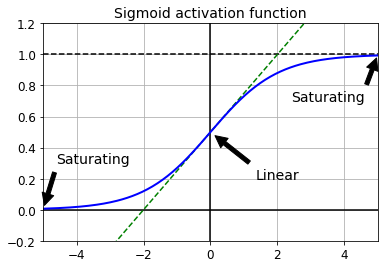

In [69]:
# Logit / Sigmoid function plot

def logit(z):
    return 1 / (1 + np.exp(-z))


z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

## He Initialization

In [68]:
import tensorflow as tf

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

/usr/local/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Nonsaturating Activation Functions

### Leaky ReLU

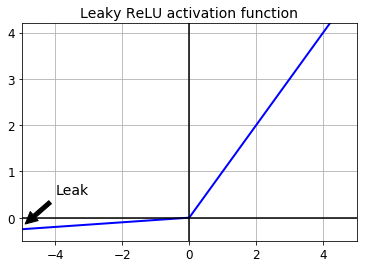

In [71]:
# Leaky ReLU plot 

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [72]:
# Implementing Leaky ReLU in TensorFlow

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

## Let's train a neural network on MNIST using the Leaky ReLU

### Step 1- First let's create the graph

In [73]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [74]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [75]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [76]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [77]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [78]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [79]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Step 2- Now let's load the data

In [85]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [81]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.951
10 Batch accuracy: 0.96 Validation accuracy: 0.9666
15 Batch accuracy: 1.0 Validation accuracy: 0.9722
20 Batch accuracy: 1.0 Validation accuracy: 0.9748
25 Batch accuracy: 1.0 Validation accuracy: 0.9768
30 Batch accuracy: 0.98 Validation accuracy: 0.9778
35 Batch accuracy: 0.96 Validation accuracy: 0.9796


### ELU

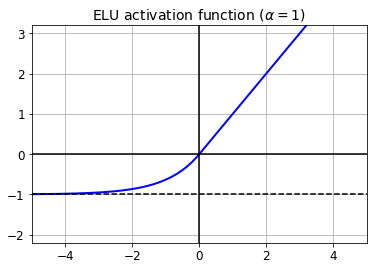

In [82]:
# ELU plot

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [83]:
# Implementing ELU in TensorFlow
# Just specify the activation function when building each layer
    
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU Activation Function

In [84]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

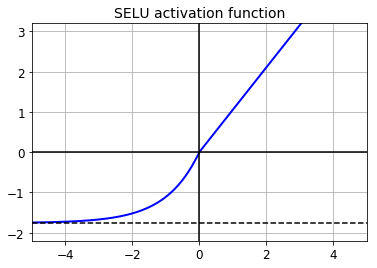

In [85]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [86]:
# Check the mean and standard deviation in the deep layers for SELU activation function

np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


### Let's create a neural net for MNIST using the SELU activation function

In [87]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [88]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "model_ckps/my_model_final_selu.ckpt")

0 Batch accuracy: 0.92 Validation accuracy: 0.9264
5 Batch accuracy: 1.0 Validation accuracy: 0.9554
10 Batch accuracy: 0.94 Validation accuracy: 0.9636
15 Batch accuracy: 0.98 Validation accuracy: 0.9658
20 Batch accuracy: 1.0 Validation accuracy: 0.969
25 Batch accuracy: 1.0 Validation accuracy: 0.9706
30 Batch accuracy: 1.0 Validation accuracy: 0.9696
35 Batch accuracy: 1.0 Validation accuracy: 0.969


# Batch Normalization

In [89]:
# Let's implement Batch Normalization with TensorFlow

reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

# Set Training. Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder)
# Whether to return the output in training mode (normalized with statistics of the current batch) 
# or in inference mode (normalized with moving statistics)

training = tf.placeholder_with_default(False, shape=(), name='training')


hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")

# We will discuss momentum later in the course

bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [90]:
# In previous example, we passed parameters repeatedly to batch_normalization function
# To avoid repeating the same parameters over and over again, we can use Python's partial() function 
# Let's improve previous example with partial() 

from functools import partial


reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [91]:
# Now let's build a neural net for MNIST
# Using the ELU activation function and Batch Normalization at each layer

reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [92]:
# Execution phase

n_epochs = 20
batch_size = 200

# When is_training is True the moving_mean and moving_variance need to be updated by running these commands
# extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# sess.run([train_op, extra_update_ops], ...)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.8666
1 Test accuracy: 0.894
2 Test accuracy: 0.9088
3 Test accuracy: 0.9189
4 Test accuracy: 0.9262
5 Test accuracy: 0.9334
6 Test accuracy: 0.9379
7 Test accuracy: 0.942
8 Test accuracy: 0.9444
9 Test accuracy: 0.9477
10 Test accuracy: 0.9499
11 Test accuracy: 0.952
12 Test accuracy: 0.9546
13 Test accuracy: 0.956
14 Test accuracy: 0.9567
15 Test accuracy: 0.9591
16 Test accuracy: 0.9609
17 Test accuracy: 0.9612
18 Test accuracy: 0.9618
19 Test accuracy: 0.9635


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [93]:
# List trainable variables

[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [94]:
# List global variables

[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping

In [77]:
# Create a simple neural net for MNIST and add gradient clipping

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [81]:
# Now we apply gradient clipping.
# For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them

learning_rate = 0.01

threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same as usual:

In [87]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 40
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.5123
1 Test accuracy: 0.8229
2 Test accuracy: 0.8822
3 Test accuracy: 0.9006
4 Test accuracy: 0.9105
5 Test accuracy: 0.9237
6 Test accuracy: 0.93
7 Test accuracy: 0.9346
8 Test accuracy: 0.94
9 Test accuracy: 0.9439
10 Test accuracy: 0.9453
11 Test accuracy: 0.9487
12 Test accuracy: 0.9498
13 Test accuracy: 0.9503
14 Test accuracy: 0.953
15 Test accuracy: 0.9543
16 Test accuracy: 0.9571
17 Test accuracy: 0.9587
18 Test accuracy: 0.9551
19 Test accuracy: 0.9588
20 Test accuracy: 0.9609
21 Test accuracy: 0.9609
22 Test accuracy: 0.962
23 Test accuracy: 0.962
24 Test accuracy: 0.9649
25 Test accuracy: 0.9652
26 Test accuracy: 0.9664
27 Test accuracy: 0.964
28 Test accuracy: 0.966
29 Test accuracy: 0.9641
30 Test accuracy: 0.9663
31 Test accuracy: 0.9679
32 Test accuracy: 0.9665
33 Test accuracy: 0.9687
34 Test accuracy: 0.9689
35 Test accuracy: 0.9688
36 Test accuracy: 0.97
37 Test accuracy: 0.9708
38 Test accuracy: 0.9702
39 Test accuracy: 0.9703


## Reusing Pretrained Layers

## Reusing a TensorFlow Model

In [89]:
# Reusing a TensorFlow Model - Step 1

reset_graph()
saver = tf.train.import_meta_graph("model_ckps/my_model_final.ckpt.meta")

In [90]:
# Reusing a TensorFlow Model - Step 2
# List all the operations using below code

for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros/shape_as_tensor
hidden1/bias/Initializer/zeros/Const
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read


In [92]:
# Reusing a TensorFlow Model - Step 3
# Once we know which operations do we need then
# we can get a handle on them using the graph's get_operation_by_name() or get_tensor_by_name() methods

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [93]:
# Reusing a TensorFlow Model - Step 4
# Now you can start a session, restore the model's state and continue training on your data

with tf.Session() as sess:
    saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from model_ckps/my_model_final.ckpt
0 Test accuracy: 0.9709
1 Test accuracy: 0.9701
2 Test accuracy: 0.971
3 Test accuracy: 0.9716
4 Test accuracy: 0.9712
5 Test accuracy: 0.9719
6 Test accuracy: 0.9712
7 Test accuracy: 0.9716
8 Test accuracy: 0.9726
9 Test accuracy: 0.9719
10 Test accuracy: 0.9714
11 Test accuracy: 0.9727
12 Test accuracy: 0.9718
13 Test accuracy: 0.9724
14 Test accuracy: 0.9734
15 Test accuracy: 0.9732
16 Test accuracy: 0.9717
17 Test accuracy: 0.9738
18 Test accuracy: 0.9736
19 Test accuracy: 0.9734
20 Test accuracy: 0.9729
21 Test accuracy: 0.9728
22 Test accuracy: 0.9725
23 Test accuracy: 0.9735
24 Test accuracy: 0.9734
25 Test accuracy: 0.9732
26 Test accuracy: 0.9728
27 Test accuracy: 0.9732
28 Test accuracy: 0.9735
29 Test accuracy: 0.9735
30 Test accuracy: 0.9736
31 Test accuracy: 0.9736
32 Test accuracy: 0.9729
33 Test accuracy: 0.9721
34 Test accuracy: 0.9729
35 Test accuracy: 0.9731
36 Test accuracy: 0.9734
37 Test accur

### Reusing only part of the original model

In [102]:
# In general, we restore only early layers
# Let's restore only hidden layers 1, 2 and 3

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):                                     
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from model_ckps/my_model_final.ckpt
0 Test accuracy: 0.9445
1 Test accuracy: 0.9518
2 Test accuracy: 0.9522
3 Test accuracy: 0.9559
4 Test accuracy: 0.9554
5 Test accuracy: 0.9598
6 Test accuracy: 0.9608
7 Test accuracy: 0.9617
8 Test accuracy: 0.9635
9 Test accuracy: 0.9643
10 Test accuracy: 0.9651
11 Test accuracy: 0.9658
12 Test accuracy: 0.9662
13 Test accuracy: 0.9678
14 Test accuracy: 0.9668
15 Test accuracy: 0.9684
16 Test accuracy: 0.9681
17 Test accuracy: 0.9681
18 Test accuracy: 0.9685
19 Test accuracy: 0.9662


## Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

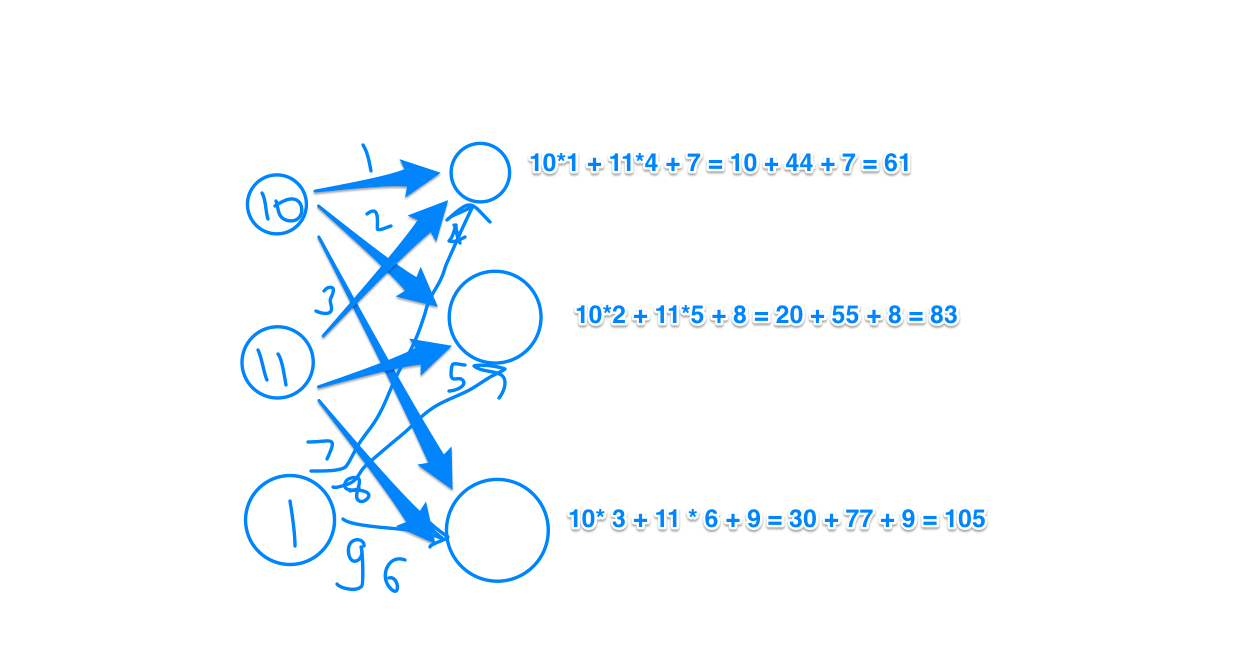

In [103]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[  61.   83.  105.]]


In [99]:
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
assign_kernel.inputs[1]

<tf.Tensor 'hidden1/kernel/Initializer/random_uniform:0' shape=(784, 300) dtype=float32>

# Faster Optimizers

## Momentum optimization

In [107]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov Accelerated Gradient

In [108]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [109]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [110]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization

In [111]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

In [112]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [113]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [114]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [115]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.9607
1 Test accuracy: 0.9723
2 Test accuracy: 0.9727
3 Test accuracy: 0.98
4 Test accuracy: 0.9803


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [120]:
# Let's implement ℓ1 regularization manually.
# Assuming we have just one hidden layer

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [121]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [122]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [123]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.8338
1 Test accuracy: 0.8694
2 Test accuracy: 0.8835
3 Test accuracy: 0.8909
4 Test accuracy: 0.8948
5 Test accuracy: 0.8984
6 Test accuracy: 0.9014
7 Test accuracy: 0.9035
8 Test accuracy: 0.9038
9 Test accuracy: 0.905
10 Test accuracy: 0.9063
11 Test accuracy: 0.907
12 Test accuracy: 0.9078
13 Test accuracy: 0.9074
14 Test accuracy: 0.9072
15 Test accuracy: 0.9075
16 Test accuracy: 0.9073
17 Test accuracy: 0.9069
18 Test accuracy: 0.9069
19 Test accuracy: 0.9058


### Go back to notebook

### Applying ℓ1 regularization in the network having two hidden layers

Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [124]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [125]:
scale = 0.001

In [126]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

Next we must add the regularization losses to the base loss:

In [127]:
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [129]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [130]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.8348
1 Test accuracy: 0.8791
2 Test accuracy: 0.8933
3 Test accuracy: 0.9011
4 Test accuracy: 0.9055
5 Test accuracy: 0.9114
6 Test accuracy: 0.9123
7 Test accuracy: 0.9145
8 Test accuracy: 0.9156
9 Test accuracy: 0.9172
10 Test accuracy: 0.9181
11 Test accuracy: 0.9187
12 Test accuracy: 0.9184
13 Test accuracy: 0.9193
14 Test accuracy: 0.9201
15 Test accuracy: 0.919
16 Test accuracy: 0.9188
17 Test accuracy: 0.9191
18 Test accuracy: 0.918
19 Test accuracy: 0.9176


## Dropout

In [147]:
# Apply dropout regularization to three-layer neural network

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [148]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5

# Apply dropout to input layer 
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    
    # Apply dropout to the first hidden layer
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    
    # Apply dropout to the second hidden layer
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [149]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [150]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.9203
1 Test accuracy: 0.9381
2 Test accuracy: 0.9491
3 Test accuracy: 0.9546
4 Test accuracy: 0.9585
5 Test accuracy: 0.9589
6 Test accuracy: 0.9605
7 Test accuracy: 0.962
8 Test accuracy: 0.9604
9 Test accuracy: 0.9625
10 Test accuracy: 0.9631
11 Test accuracy: 0.9698
12 Test accuracy: 0.9666
13 Test accuracy: 0.9671
14 Test accuracy: 0.9682
15 Test accuracy: 0.9678
16 Test accuracy: 0.9684
17 Test accuracy: 0.9688
18 Test accuracy: 0.9665
19 Test accuracy: 0.9698


## Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [101]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [102]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [103]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [104]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [105]:
n_epochs = 20
batch_size = 50

In [106]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for iteration in range(mnist.train.num_examples // batch_size):  # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)       # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,       # not shown
                                            y: mnist.test.labels})      # not shown
        print(epoch, "Test accuracy:", acc_test)                        # not shown

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")               # not shown

0 Test accuracy: 0.9517
1 Test accuracy: 0.9674
2 Test accuracy: 0.9712
3 Test accuracy: 0.9759
4 Test accuracy: 0.975
5 Test accuracy: 0.9761
6 Test accuracy: 0.9765
7 Test accuracy: 0.9796
8 Test accuracy: 0.9791
9 Test accuracy: 0.9794
10 Test accuracy: 0.9805
11 Test accuracy: 0.9809
12 Test accuracy: 0.9807
13 Test accuracy: 0.9799
14 Test accuracy: 0.982
15 Test accuracy: 0.9816
16 Test accuracy: 0.9825
17 Test accuracy: 0.9825
18 Test accuracy: 0.9816
19 Test accuracy: 0.9822


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [107]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [108]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [109]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [110]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [111]:
n_epochs = 20
batch_size = 50

In [112]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,     # not shown in the book
                                            y: mnist.test.labels})    # not shown
        print(epoch, "Test accuracy:", acc_test)                      # not shown

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")             # not shown

0 Test accuracy: 0.9527
1 Test accuracy: 0.9653
2 Test accuracy: 0.97
3 Test accuracy: 0.9751
4 Test accuracy: 0.9752
5 Test accuracy: 0.9742
6 Test accuracy: 0.9754
7 Test accuracy: 0.9784
8 Test accuracy: 0.9775
9 Test accuracy: 0.9789
10 Test accuracy: 0.9808
11 Test accuracy: 0.9797
12 Test accuracy: 0.9802
13 Test accuracy: 0.9799
14 Test accuracy: 0.9808
15 Test accuracy: 0.9809
16 Test accuracy: 0.9807
17 Test accuracy: 0.9803
18 Test accuracy: 0.9816
19 Test accuracy: 0.9812


## Dummy Example of Standard Normalization

In [54]:
import numpy as np
x = np.array([0.1, 0.01, 1,100, 200, 400, 50000, 100000])
mean = np.sum(x)/len(x)

In [55]:
mean

18837.63875

In [56]:
d = x - mean
ssq = np.sum(d*d)/len(x)

In [57]:
d

array([-18837.53875, -18837.62875, -18836.63875, -18737.63875,
       -18637.63875, -18437.63875,  31162.36125,  81162.36125])

In [58]:
d/np.sqrt(ssq)

array([-0.5420634 , -0.54206599, -0.54203751, -0.53918871, -0.53631114,
       -0.530556  ,  0.89671883,  2.33550394])

## Dummy Example of Clipping

In [63]:

a = [(3.4, "x"), (1.8, "y"), (-2.9, "z"), (-3.1, "zz")]

In [64]:
def clip_by_value(x, th):
    if x < -th:
        return -th;
    if x> th:
        return th
    return x

In [65]:
b = []
th = 3
for (k, v) in a:
    b.append((clip_by_value(k, th), v))
b

[(3, 'x'), (1.8, 'y'), (-2.9, 'z'), (-3, 'zz')]

In [66]:
th = 3
[(clip_by_value(k, th), v) for (k, v) in a]

[(3, 'x'), (1.8, 'y'), (-2.9, 'z'), (-3, 'zz')]

## Partial Function

In [74]:
from functools import partial
def multiply(x, y):
    return x*y
multiplyByTwo = partial(multiply, 2)

def multiplyByTwo_1(x):
    return multiply(x, 2)

In [73]:
multiplyByTwo(4)

8

In [75]:
multiplyByTwo_1(4)

8